In [1]:
#%pip install -r requirements.txt

import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm

In [ ]:
##################################__DATA LOAD__################################################

In [2]:
interest_rate = pd.read_csv('./data/interest_rate.csv')
energy_price = pd.read_csv('./data/energy_price.csv')
cpi = pd.read_csv('./data/cpi.csv')

In [ ]:
##################################__DATA SANITY CHECKS__################################################

In [3]:
interest_rate.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term
0,AUS,7.177895,2000,1,5.66,5.00
1,AUS,6.957619,2000,2,5.80,5.48
2,AUS,6.570435,2000,3,5.89,5.50
3,AUS,6.264706,2000,4,6.04,5.72
4,AUS,6.465652,2000,5,6.31,5.98
...,...,...,...,...,...,...
995,USA,2.530000,2014,9,0.12,0.09
996,USA,2.300000,2014,10,0.12,0.09
997,USA,2.330000,2014,11,0.13,0.09
998,USA,2.210000,2014,12,0.15,0.12


In [5]:
cpi.head(2000)

,location,cpi-index,year,month
0,AUS,3.700000,1948,9
1,AUS,3.733333,1948,10
2,AUS,3.766667,1948,11
3,AUS,3.800000,1948,12
4,AUS,3.833333,1949,1
...,...,...,...,...
1575,EU,117.010000,2022,6
1576,EU,117.140000,2022,7
1577,EU,117.850000,2022,8
1578,EU,119.260000,2022,9


In [6]:
energy_price.head(1000)

,energy_price,year,month,energy_price_lag_1m,energy_price_lag_2m,energy_price_lag_3m,energy_price_lag_4m,energy_price_lag_5m,energy_price_lag_6m,energy_price_lag_7m,...,energy_price_lag_40m,energy_price_lag_41m,energy_price_lag_42m,energy_price_lag_43m,energy_price_lag_44m,energy_price_lag_45m,energy_price_lag_46m,energy_price_lag_47m,energy_price_lag_48m,location
0,50.870,2007,1,58.015,55.275,55.020,58.850,68.240,68.460,64.715,...,26.360,28.800,27.380,26.700,26.170,25.380,29.800,31.845,30.430,AUS
1,53.995,2007,2,50.870,58.015,55.275,55.020,58.850,68.240,68.460,...,28.160,26.360,28.800,27.380,26.700,26.170,25.380,29.800,31.845,AUS
2,58.055,2007,3,53.995,50.870,58.015,55.275,55.020,58.850,68.240,...,28.515,28.160,26.360,28.800,27.380,26.700,26.170,25.380,29.800,AUS
3,63.785,2007,4,58.055,53.995,50.870,58.015,55.275,55.020,58.850,...,29.640,28.515,28.160,26.360,28.800,27.380,26.700,26.170,25.380,AUS
4,64.450,2007,5,63.785,58.055,53.995,50.870,58.015,55.275,55.020,...,30.370,29.640,28.515,28.160,26.360,28.800,27.380,26.700,26.170,AUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,18.965,1993,3,18.960,18.700,18.045,16.705,16.900,16.520,16.640,...,19.610,19.895,22.920,23.840,23.050,23.325,23.455,20.785,19.760,EU
845,18.410,1993,2,18.965,18.960,18.700,18.045,16.705,16.900,16.520,...,18.360,19.610,19.895,22.920,23.840,23.050,23.325,23.455,20.785,EU
846,17.755,1993,1,18.410,18.965,18.960,18.700,18.045,16.705,16.900,...,18.230,18.360,19.610,19.895,22.920,23.840,23.050,23.325,23.455,EU
847,18.290,1992,12,17.755,18.410,18.965,18.960,18.700,18.045,16.705,...,20.690,18.230,18.360,19.610,19.895,22.920,23.840,23.050,23.325,EU


In [7]:
df = interest_rate.merge(cpi, on=['location', 'year', 'month'], suffixes=('', '_delme'))
df = df.merge(energy_price, on=['location', 'year', 'month'], suffixes=('', '_delme'))
df = df[[c for c in df.columns if not c.endswith('_delme')]]

In [13]:
df.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_1m,energy_price_lag_2m,...,energy_price_lag_39m,energy_price_lag_40m,energy_price_lag_41m,energy_price_lag_42m,energy_price_lag_43m,energy_price_lag_44m,energy_price_lag_45m,energy_price_lag_46m,energy_price_lag_47m,energy_price_lag_48m
0,AUS,5.877619,2007,1,6.43,6.25,86.600000,50.870,58.015,55.275,...,28.160,26.360,28.800,27.380,26.70,26.17,25.38,29.80,31.845,30.430
1,AUS,5.809250,2007,2,6.37,6.25,86.600000,53.995,50.870,58.015,...,28.515,28.160,26.360,28.800,27.38,26.70,26.17,25.38,29.800,31.845
2,AUS,5.736818,2007,3,6.43,6.25,86.600000,58.055,53.995,50.870,...,29.640,28.515,28.160,26.360,28.80,27.38,26.70,26.17,25.380,29.800
3,AUS,5.909722,2007,4,6.48,6.25,86.966667,63.785,58.055,53.995,...,30.370,29.640,28.515,28.160,26.36,28.80,27.38,26.70,26.170,25.380
4,AUS,5.920869,2007,5,6.37,6.25,87.333333,64.450,63.785,58.055,...,29.730,30.370,29.640,28.515,28.16,26.36,28.80,27.38,26.700,26.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,USA,2.900000,2022,5,1.33,0.77,292.296000,109.550,101.780,108.500,...,54.950,51.380,49.520,56.960,70.75,70.23,68.06,70.98,67.870,69.980
684,USA,3.140000,2022,6,1.87,1.21,296.311000,114.840,109.550,101.780,...,58.150,54.950,51.380,49.520,56.96,70.75,70.23,68.06,70.980,67.870
685,USA,2.900000,2022,7,2.50,1.68,296.276000,101.620,114.840,109.550,...,63.860,58.150,54.950,51.380,49.52,56.96,70.75,70.23,68.060,70.980
686,USA,2.900000,2022,8,2.76,2.33,296.171000,93.670,101.620,114.840,...,60.830,63.860,58.150,54.950,51.38,49.52,56.96,70.75,70.230,68.060


In [14]:
#Columns present in the dataset
df.columns

Index(['location', 'interest_rate_long_term', 'year', 'month',
       'interest_rate_short_term', 'interest_rate_immediate_term', 'cpi-index',
       'energy_price', 'energy_price_lag_1m', 'energy_price_lag_2m',
       'energy_price_lag_3m', 'energy_price_lag_4m', 'energy_price_lag_5m',
       'energy_price_lag_6m', 'energy_price_lag_7m', 'energy_price_lag_8m',
       'energy_price_lag_9m', 'energy_price_lag_10m', 'energy_price_lag_11m',
       'energy_price_lag_12m', 'energy_price_lag_13m', 'energy_price_lag_14m',
       'energy_price_lag_15m', 'energy_price_lag_16m', 'energy_price_lag_17m',
       'energy_price_lag_18m', 'energy_price_lag_19m', 'energy_price_lag_20m',
       'energy_price_lag_21m', 'energy_price_lag_22m', 'energy_price_lag_23m',
       'energy_price_lag_24m', 'energy_price_lag_25m', 'energy_price_lag_26m',
       'energy_price_lag_27m', 'energy_price_lag_28m', 'energy_price_lag_29m',
       'energy_price_lag_30m', 'energy_price_lag_31m', 'energy_price_lag_32m',
     

In [15]:
#Checking for null values
df.isnull().sum()

location                        0
interest_rate_long_term         0
year                            0
month                           0
interest_rate_short_term        0
interest_rate_immediate_term    0
cpi-index                       0
energy_price                    0
energy_price_lag_1m             0
energy_price_lag_2m             0
energy_price_lag_3m             0
energy_price_lag_4m             0
energy_price_lag_5m             0
energy_price_lag_6m             0
energy_price_lag_7m             0
energy_price_lag_8m             0
energy_price_lag_9m             0
energy_price_lag_10m            0
energy_price_lag_11m            0
energy_price_lag_12m            0
energy_price_lag_13m            0
energy_price_lag_14m            0
energy_price_lag_15m            0
energy_price_lag_16m            0
energy_price_lag_17m            0
energy_price_lag_18m            0
energy_price_lag_19m            0
energy_price_lag_20m            0
energy_price_lag_21m            0
energy_price_l

In [16]:
#Checking datatypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 688 entries, 0 to 687
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   location                      688 non-null    object 
 1   interest_rate_long_term       688 non-null    float64
 2   year                          688 non-null    int64  
 3   month                         688 non-null    int64  
 4   interest_rate_short_term      688 non-null    float64
 5   interest_rate_immediate_term  688 non-null    float64
 6   cpi-index                     688 non-null    float64
 7   energy_price                  688 non-null    float64
 8   energy_price_lag_1m           688 non-null    float64
 9   energy_price_lag_2m           688 non-null    float64
 10  energy_price_lag_3m           688 non-null    float64
 11  energy_price_lag_4m           688 non-null    float64
 12  energy_price_lag_5m           688 non-null    float64
 13  energ

In [17]:
#Stats of data
df.describe()

,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_1m,energy_price_lag_2m,energy_price_lag_3m,...,energy_price_lag_39m,energy_price_lag_40m,energy_price_lag_41m,energy_price_lag_42m,energy_price_lag_43m,energy_price_lag_44m,energy_price_lag_45m,energy_price_lag_46m,energy_price_lag_47m,energy_price_lag_48m
count,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,...,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,3.373614,2011.194767,6.456395,2.427312,2.214702,146.830337,66.856235,66.744520,66.591221,66.440574,...,64.980930,65.019535,65.029215,65.024041,65.045414,65.051330,65.064753,65.064906,65.056824,65.013074
std,1.442873,6.085980,3.440213,2.106684,2.068305,64.510095,28.074615,28.076185,28.066032,28.007621,...,28.380479,28.490129,28.567205,28.677442,28.791748,28.882538,28.952210,29.011666,29.074778,29.135264
min,0.620000,2000.000000,1.000000,0.010000,0.050000,74.860000,17.730000,16.550000,16.550000,16.550000,...,11.280000,11.280000,11.280000,11.280000,11.280000,11.280000,11.280000,11.280000,11.280000,11.280000
25%,2.169900,2007.000000,3.000000,0.554710,0.422600,95.125000,45.187500,45.187500,45.180000,45.180000,...,44.603750,44.557500,44.305000,43.927500,43.911250,43.836250,43.600000,43.310000,43.207500,43.207500
50%,3.350000,2011.000000,6.000000,1.820000,1.500000,109.500000,63.822500,63.675000,63.425000,63.295000,...,62.432500,62.532500,62.532500,62.425000,62.425000,62.425000,62.532500,62.657500,62.657500,62.532500
75%,4.606875,2016.000000,9.000000,4.200000,4.087575,211.818000,89.572500,89.457500,89.133750,88.595000,...,86.098750,86.232500,86.350000,86.472500,86.791250,87.371250,88.010000,88.253750,88.346250,88.595000
max,6.660000,2022.000000,12.000000,7.900000,7.250000,296.808000,134.190000,134.190000,134.190000,134.190000,...,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000


In [18]:
df.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_1m,energy_price_lag_2m,...,energy_price_lag_39m,energy_price_lag_40m,energy_price_lag_41m,energy_price_lag_42m,energy_price_lag_43m,energy_price_lag_44m,energy_price_lag_45m,energy_price_lag_46m,energy_price_lag_47m,energy_price_lag_48m
0,AUS,5.877619,2007,1,6.43,6.25,86.600000,50.870,58.015,55.275,...,28.160,26.360,28.800,27.380,26.70,26.17,25.38,29.80,31.845,30.430
1,AUS,5.809250,2007,2,6.37,6.25,86.600000,53.995,50.870,58.015,...,28.515,28.160,26.360,28.800,27.38,26.70,26.17,25.38,29.800,31.845
2,AUS,5.736818,2007,3,6.43,6.25,86.600000,58.055,53.995,50.870,...,29.640,28.515,28.160,26.360,28.80,27.38,26.70,26.17,25.380,29.800
3,AUS,5.909722,2007,4,6.48,6.25,86.966667,63.785,58.055,53.995,...,30.370,29.640,28.515,28.160,26.36,28.80,27.38,26.70,26.170,25.380
4,AUS,5.920869,2007,5,6.37,6.25,87.333333,64.450,63.785,58.055,...,29.730,30.370,29.640,28.515,28.16,26.36,28.80,27.38,26.700,26.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,USA,2.900000,2022,5,1.33,0.77,292.296000,109.550,101.780,108.500,...,54.950,51.380,49.520,56.960,70.75,70.23,68.06,70.98,67.870,69.980
684,USA,3.140000,2022,6,1.87,1.21,296.311000,114.840,109.550,101.780,...,58.150,54.950,51.380,49.520,56.96,70.75,70.23,68.06,70.980,67.870
685,USA,2.900000,2022,7,2.50,1.68,296.276000,101.620,114.840,109.550,...,63.860,58.150,54.950,51.380,49.52,56.96,70.75,70.23,68.060,70.980
686,USA,2.900000,2022,8,2.76,2.33,296.171000,93.670,101.620,114.840,...,60.830,63.860,58.150,54.950,51.38,49.52,56.96,70.75,70.230,68.060


In [ ]:
##################################__Data Prep__################################################

In [20]:
df_au = df[df['location'] == 'AUS']
df_us = df[df['location'] == 'USA']
df_eu = df[df['location'] == 'EU']

In [ ]:
##################################__Linear Regression__################################################

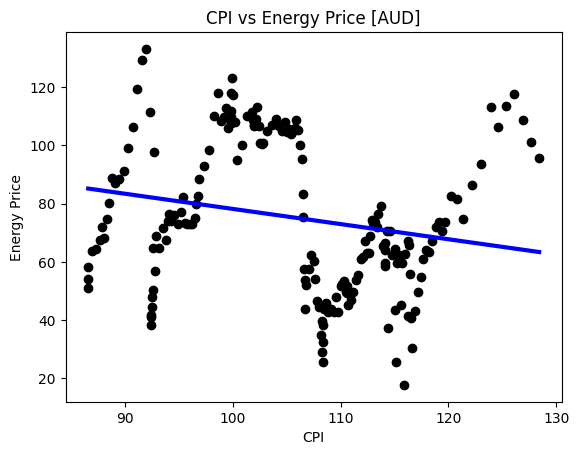

In [21]:
#cpi vs enery_price [aud]
regr = linear_model.LinearRegression()
x = df_au[['cpi-index']]
y = df_au[['energy_price']]
regr.fit(x,y)

plt.scatter(x,y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.title('CPI vs Energy Price [AUD]')
plt.xlabel('CPI')
plt.ylabel('Energy Price')
plt.show()

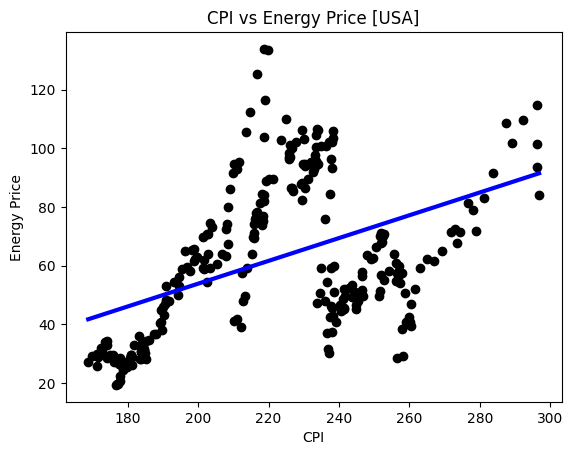

In [22]:
#cpi vs enery_price [usa]
regr = linear_model.LinearRegression()
x = df_us[['cpi-index']]
y = df_us[['energy_price']]
regr.fit(x,y)

plt.scatter(x,y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.title('CPI vs Energy Price [USA]')
plt.xlabel('CPI')
plt.ylabel('Energy Price')
plt.show()

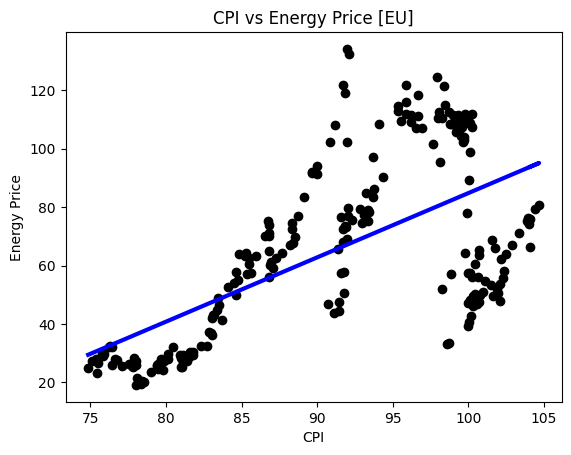

In [23]:
#cpi vs enery_price [EU]
regr = linear_model.LinearRegression()
x = df_eu[['cpi-index']]
y = df_eu[['energy_price']]
regr.fit(x,y)

plt.scatter(x,y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.title('CPI vs Energy Price [EU]')
plt.xlabel('CPI')
plt.ylabel('Energy Price')
plt.show()

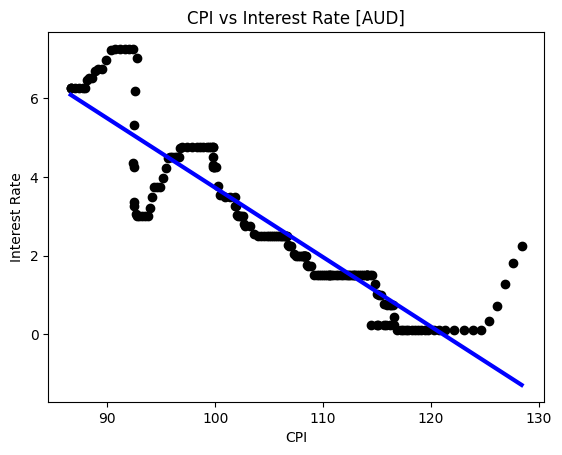

In [24]:
#cpi vs interest_rate_immediate_term [aud]
regr = linear_model.LinearRegression()
x = df_au[['cpi-index']]
y = df_au[['interest_rate_immediate_term']]
regr.fit(x,y)

plt.scatter(x,y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.title('CPI vs Interest Rate [AUD]')
plt.xlabel('CPI')
plt.ylabel('Interest Rate')
plt.show()

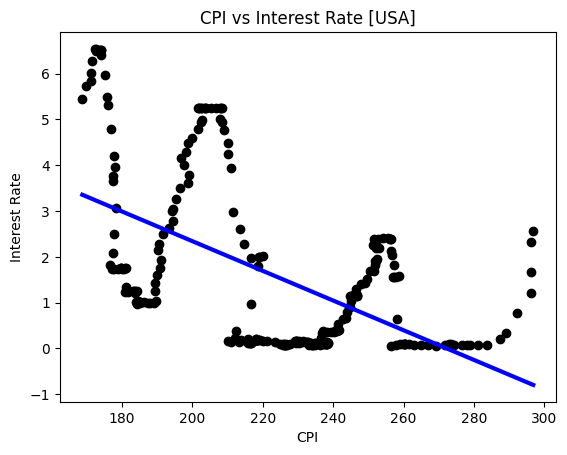

In [25]:
#cpi vs interest_rate_immediate_term [usa]
regr = linear_model.LinearRegression()
x = df_us[['cpi-index']]
y = df_us[['interest_rate_immediate_term']]
regr.fit(x,y)

plt.scatter(x,y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.title('CPI vs Interest Rate [USA]')
plt.xlabel('CPI')
plt.ylabel('Interest Rate')
plt.show()

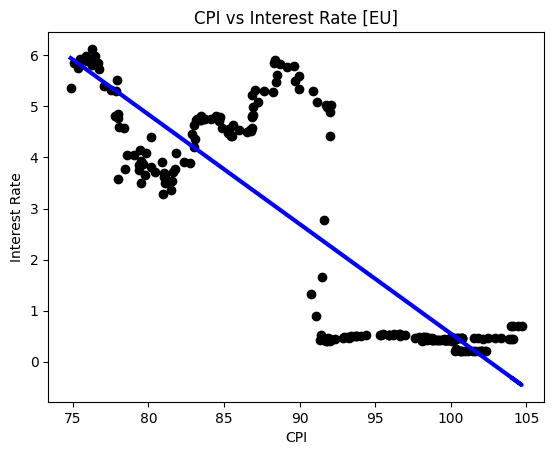

In [26]:
#cpi vs interest_rate_immediate_term [EU]
regr = linear_model.LinearRegression()
x = df_eu[['cpi-index']]
y = df_eu[['interest_rate_immediate_term']]
regr.fit(x,y)

plt.scatter(x,y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.title('CPI vs Interest Rate [EU]')
plt.xlabel('CPI')
plt.ylabel('Interest Rate')
plt.show()

In [ ]:
##################################__CORELATION__################################################

In [50]:
method='pearson'
min_periods=1

,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_1m,energy_price_lag_2m,energy_price_lag_3m,...,energy_price_lag_39m,energy_price_lag_40m,energy_price_lag_41m,energy_price_lag_42m,energy_price_lag_43m,energy_price_lag_44m,energy_price_lag_45m,energy_price_lag_46m,energy_price_lag_47m,energy_price_lag_48m
interest_rate_long_term,1.000000,-0.891298,-0.040650,0.916869,0.904480,-0.861677,0.449249,0.433818,0.406427,0.374469,...,-0.161198,-0.177241,-0.191064,-0.203808,-0.215180,-0.229054,-0.247602,-0.265864,-0.281183,-0.296449
year,-0.891298,1.000000,-0.034884,-0.906092,-0.922211,0.990401,-0.276448,-0.280868,-0.285323,-0.291586,...,0.128875,0.147248,0.162568,0.178803,0.195727,0.212817,0.231060,0.246458,0.257346,0.262961
month,-0.040650,-0.034884,1.000000,-0.020849,-0.020902,0.033470,0.001544,0.050197,0.078167,0.082848,...,0.117647,0.101083,0.070652,0.028283,-0.006379,-0.033266,-0.054997,-0.049242,-0.021037,0.021512
interest_rate_short_term,0.916869,-0.906092,-0.020849,1.000000,0.994628,-0.888807,0.406777,0.410440,0.404273,0.389486,...,-0.223145,-0.233668,-0.242382,-0.250757,-0.259509,-0.268378,-0.277705,-0.286619,-0.293512,-0.300786
interest_rate_immediate_term,0.904480,-0.922211,-0.020902,0.994628,1.000000,-0.907927,0.400627,0.407977,0.406816,0.397767,...,-0.226025,-0.239010,-0.250136,-0.262023,-0.273550,-0.285358,-0.296669,-0.306525,-0.315307,-0.323680
cpi-index,-0.861677,0.990401,0.033470,-0.888807,-0.907927,1.000000,-0.204798,-0.200418,-0.199823,-0.205825,...,0.183372,0.199847,0.211329,0.222829,0.235956,0.249969,0.266243,0.281759,0.293799,0.300305
energy_price,0.449249,-0.276448,0.001544,0.406777,0.400627,-0.204798,1.000000,0.964660,0.901816,0.826921,...,-0.076309,-0.082736,-0.088714,-0.094069,-0.097682,-0.101931,-0.111917,-0.119314,-0.125601,-0.130695
energy_price_lag_1m,0.433818,-0.280868,0.050197,0.410440,0.407977,-0.200418,0.964660,1.000000,0.964704,0.902162,...,-0.058480,-0.068539,-0.076700,-0.082503,-0.087245,-0.090501,-0.094033,-0.104620,-0.113377,-0.121651
energy_price_lag_2m,0.406427,-0.285323,0.078167,0.404273,0.406816,-0.199823,0.901816,0.964704,1.000000,0.964792,...,-0.038737,-0.049615,-0.061812,-0.069778,-0.074810,-0.079095,-0.081449,-0.085655,-0.097931,-0.109250
energy_price_lag_3m,0.374469,-0.291586,0.082848,0.389486,0.397767,-0.205825,0.826921,0.902162,0.964792,1.000000,...,-0.020327,-0.029527,-0.043052,-0.055060,-0.062047,-0.066502,-0.069634,-0.072611,-0.078936,-0.094592


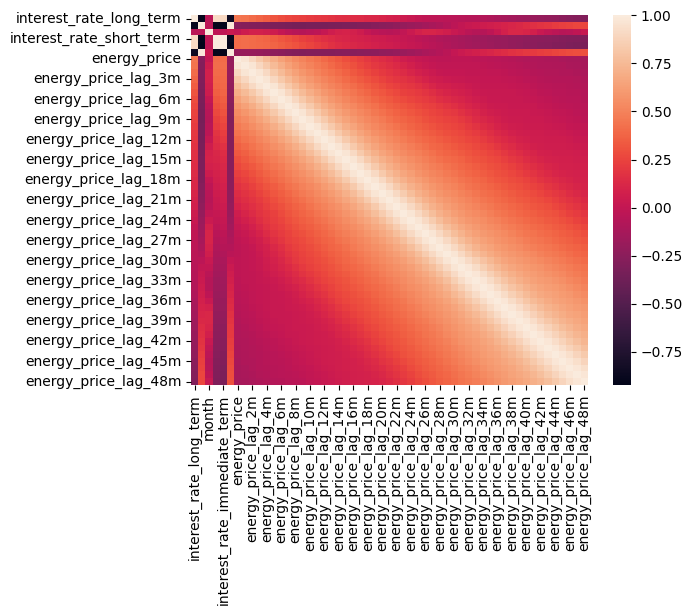

In [51]:
#au

sns.heatmap(df_au.corr(numeric_only=True,method=method, min_periods=min_periods))
df_au.corr(numeric_only=True,method=method, min_periods=min_periods)

,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_1m,energy_price_lag_2m,energy_price_lag_3m,...,energy_price_lag_39m,energy_price_lag_40m,energy_price_lag_41m,energy_price_lag_42m,energy_price_lag_43m,energy_price_lag_44m,energy_price_lag_45m,energy_price_lag_46m,energy_price_lag_47m,energy_price_lag_48m
interest_rate_long_term,1.000000,-0.863408,-0.053153,0.767289,0.769266,-0.827503,-0.302359,-0.304294,-0.313401,-0.331695,...,-0.664999,-0.664749,-0.664721,-0.661620,-0.659345,-0.658301,-0.660373,-0.661073,-0.661931,-0.664088
year,-0.863408,1.000000,-0.020812,-0.544418,-0.555717,0.986641,0.368775,0.365886,0.360595,0.358856,...,0.608082,0.614609,0.621389,0.625896,0.633048,0.639689,0.646436,0.652349,0.657132,0.659935
month,-0.053153,-0.020812,1.000000,-0.001169,-0.017956,0.019271,0.003808,0.049805,0.075716,0.077666,...,0.068313,0.054732,0.034973,0.007615,-0.013970,-0.030224,-0.040627,-0.035669,-0.010790,0.016195
interest_rate_short_term,0.767289,-0.544418,-0.001169,1.000000,0.984704,-0.511400,-0.250018,-0.239589,-0.236556,-0.242372,...,-0.623963,-0.620259,-0.616557,-0.610424,-0.604494,-0.597052,-0.587580,-0.577090,-0.566565,-0.558555
interest_rate_immediate_term,0.769266,-0.555717,-0.017956,0.984704,1.000000,-0.531066,-0.287792,-0.289416,-0.294825,-0.307738,...,-0.640619,-0.636708,-0.633336,-0.628315,-0.622683,-0.614253,-0.604162,-0.592611,-0.582367,-0.574146
cpi-index,-0.827503,0.986641,0.019271,-0.511400,-0.531066,1.000000,0.456888,0.456263,0.448270,0.440227,...,0.589454,0.594539,0.599223,0.601488,0.606999,0.612880,0.619322,0.625900,0.631370,0.633129
energy_price,-0.302359,0.368775,0.003808,-0.250018,-0.287792,0.456888,1.000000,0.975493,0.936103,0.889826,...,0.442182,0.441168,0.438628,0.436323,0.430996,0.425973,0.417140,0.410197,0.401075,0.389667
energy_price_lag_1m,-0.304294,0.365886,0.049805,-0.239589,-0.289416,0.456263,0.975493,1.000000,0.976752,0.936274,...,0.449613,0.444834,0.442567,0.441706,0.438490,0.434286,0.429465,0.421724,0.413100,0.402380
energy_price_lag_2m,-0.313401,0.360595,0.075716,-0.236556,-0.294825,0.448270,0.936103,0.976752,1.000000,0.975890,...,0.460184,0.453190,0.447516,0.445937,0.445150,0.442927,0.439040,0.434921,0.425615,0.415229
energy_price_lag_3m,-0.331695,0.358856,0.077666,-0.242372,-0.307738,0.440227,0.889826,0.936274,0.975890,1.000000,...,0.473603,0.465422,0.457463,0.451558,0.450883,0.450732,0.448888,0.445627,0.440132,0.428505


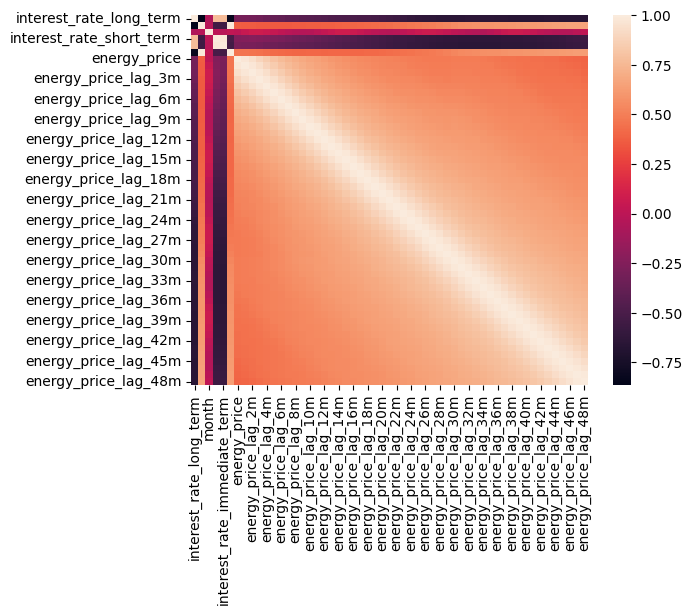

In [46]:
#us

sns.heatmap(df_us.corr(numeric_only=True,method=method, min_periods=min_periods))
df_us.corr(numeric_only=True,method=method, min_periods=min_periods)

,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_1m,energy_price_lag_2m,energy_price_lag_3m,...,energy_price_lag_39m,energy_price_lag_40m,energy_price_lag_41m,energy_price_lag_42m,energy_price_lag_43m,energy_price_lag_44m,energy_price_lag_45m,energy_price_lag_46m,energy_price_lag_47m,energy_price_lag_48m
interest_rate_long_term,1.000000,-0.926050,-0.041625,0.875132,0.866542,-0.903085,-0.361261,-0.354005,-0.351800,-0.351818,...,0.171774,0.179473,0.189349,0.196036,0.200780,0.207122,0.213465,0.220960,0.228515,0.235839
year,-0.926050,1.000000,-0.011668,-0.838623,-0.845296,0.986662,0.518640,0.510327,0.501776,0.493787,...,0.057046,0.056416,0.052148,0.049814,0.048122,0.043775,0.037405,0.029763,0.023887,0.019494
month,-0.041625,-0.011668,1.000000,-0.015599,-0.014385,0.053508,0.022378,-0.014391,-0.037339,-0.039375,...,-0.024728,-0.007540,0.011674,0.038126,0.069824,0.091620,0.103960,0.100869,0.069907,0.018943
interest_rate_short_term,0.875132,-0.838623,-0.015599,1.000000,0.991190,-0.835645,-0.411759,-0.411090,-0.411639,-0.412945,...,0.024004,0.041845,0.060312,0.074254,0.084475,0.094195,0.106922,0.122288,0.137356,0.150500
interest_rate_immediate_term,0.866542,-0.845296,-0.014385,0.991190,1.000000,-0.849562,-0.443486,-0.440691,-0.440161,-0.440717,...,-0.030380,-0.012679,0.006547,0.023421,0.035391,0.046882,0.059357,0.073580,0.089403,0.103719
cpi-index,-0.903085,0.986662,0.053508,-0.835645,-0.849562,1.000000,0.626534,0.613500,0.600204,0.588746,...,0.095323,0.092074,0.085908,0.081322,0.077424,0.071517,0.064352,0.055883,0.046814,0.037583
energy_price,-0.361261,0.518640,0.022378,-0.411759,-0.443486,0.626534,1.000000,0.985123,0.955945,0.921642,...,0.243556,0.227141,0.212095,0.195796,0.180356,0.164560,0.145755,0.128007,0.110656,0.096933
energy_price_lag_1m,-0.354005,0.510327,-0.014391,-0.411090,-0.440691,0.613500,0.985123,1.000000,0.985026,0.955537,...,0.252244,0.232064,0.216773,0.201213,0.184737,0.170378,0.154524,0.136356,0.118149,0.100588
energy_price_lag_2m,-0.351800,0.501776,-0.037339,-0.411639,-0.440161,0.600204,0.955945,0.985026,1.000000,0.984838,...,0.263816,0.241401,0.222307,0.206509,0.190777,0.175337,0.160943,0.145710,0.127104,0.108688
energy_price_lag_3m,-0.351818,0.493787,-0.039375,-0.412945,-0.440717,0.588746,0.921642,0.955537,0.984838,1.000000,...,0.275472,0.254746,0.233033,0.213620,0.197725,0.182646,0.166966,0.152918,0.137347,0.118575


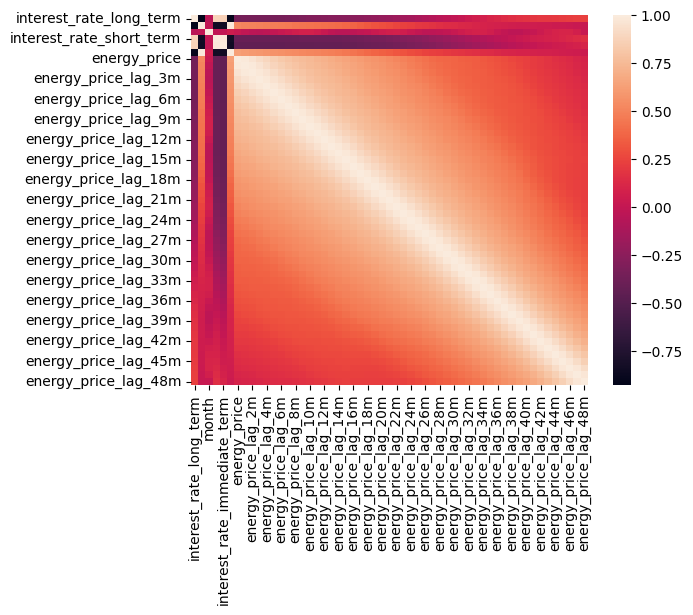

In [47]:
#eu

sns.heatmap(df_eu.corr(numeric_only=True,method=method, min_periods=min_periods))
df_eu.corr(numeric_only=True,method=method, min_periods=min_periods)

In [20]:
#sns.pairplot(df_au)

In [21]:
#sns.pairplot(df_us)

In [ ]:
##################################__CHANGE OVER TIME__################################################

array([<AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>], dtype=object)

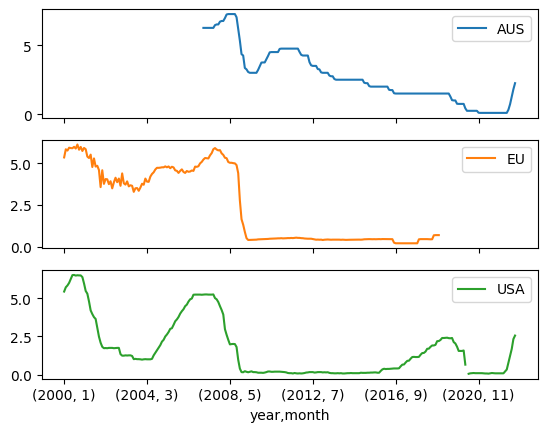

In [31]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='interest_rate_immediate_term'
              ).plot(subplots=True)

array([<AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>], dtype=object)

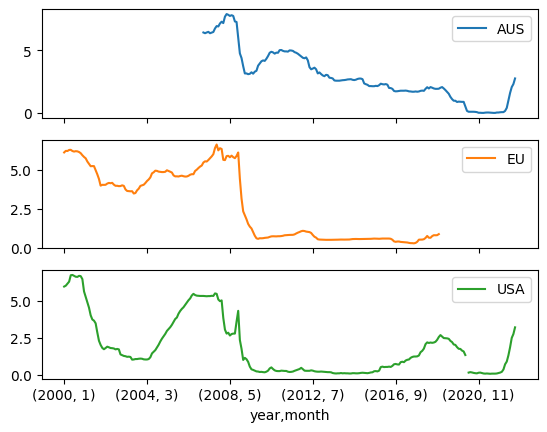

In [32]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='interest_rate_short_term'
              ).plot(subplots=True)

array([<AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>], dtype=object)

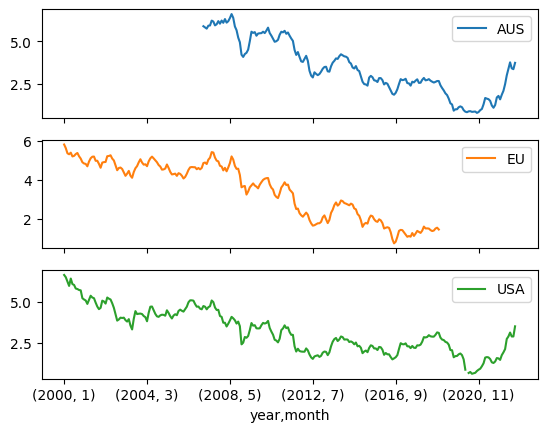

In [33]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='interest_rate_long_term'
              ).plot(subplots=True)

array([<AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>], dtype=object)

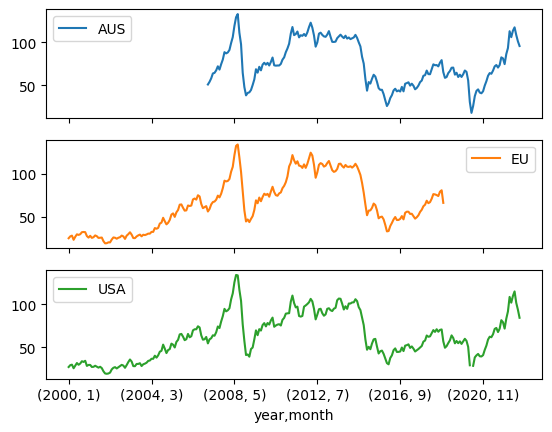

In [34]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='energy_price'
              ).plot(subplots=True)

array([<AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>], dtype=object)

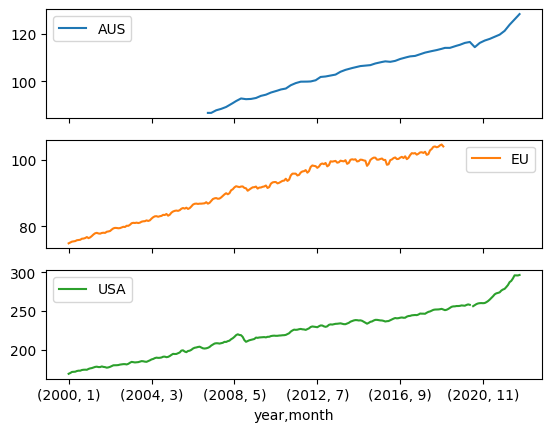

In [35]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='cpi-index'
              ).plot(subplots=True)

In [ ]:
##################################__NORMAL DISTRIBUSION__################################################

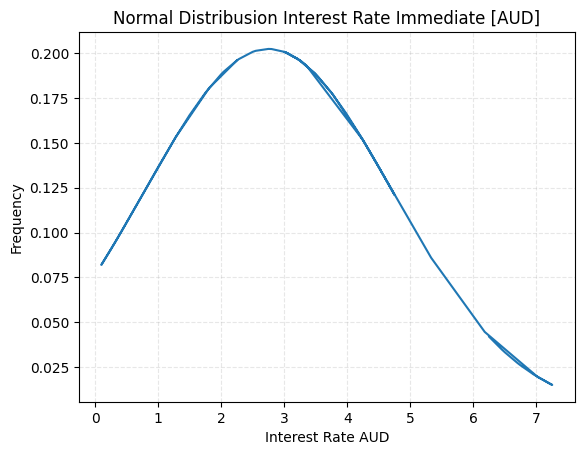

In [37]:
#normal distribusion interest rate [aud]
x = df_au['interest_rate_immediate_term']

#mean
df_mean = np.mean(x)
#standard deviation
df_std = np.std(x)

# Calculating probability density function (PDF)
pdf = norm.pdf(x, df_mean, df_std)

plt.plot(x, pdf)
plt.xlabel("Interest Rate AUD")
plt.ylabel("Frequency")  
plt.title('Normal Distribusion Interest Rate Immediate [AUD]')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

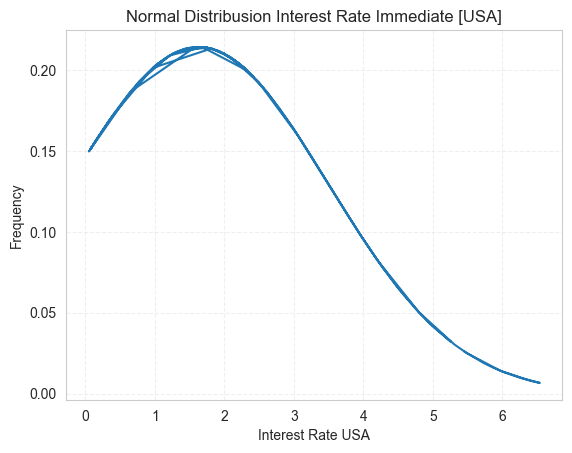

In [112]:
#normal distribusion interest rate [USA]
x = df_us['interest_rate_immediate_term']

#mean
df_mean = np.mean(x)
#standard deviation
df_std = np.std(x)

# Calculating probability density function (PDF)
pdf = norm.pdf(x, df_mean, df_std)

plt.plot(x, pdf)
plt.xlabel("Interest Rate USA")
plt.ylabel("Frequency")  
plt.title('Normal Distribusion Interest Rate Immediate [USA]')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

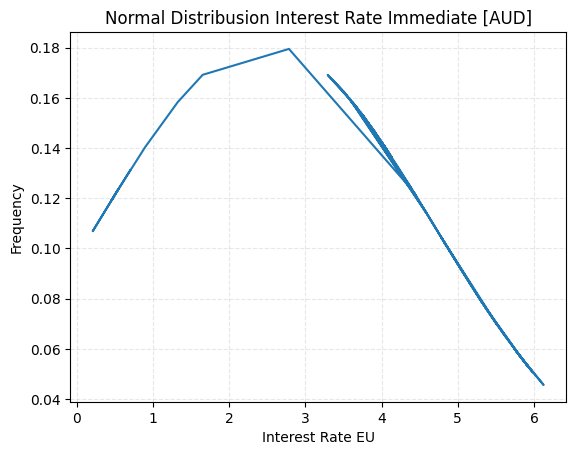

In [38]:
#normal distribusion interest rate [eu]
x = df_eu['interest_rate_immediate_term']

#mean
df_mean = np.mean(x)
#standard deviation
df_std = np.std(x)

# Calculating probability density function (PDF)
pdf = norm.pdf(x, df_mean, df_std)

plt.plot(x, pdf)
plt.xlabel("Interest Rate EU")
plt.ylabel("Frequency")  
plt.title('Normal Distribusion Interest Rate Immediate [AUD]')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

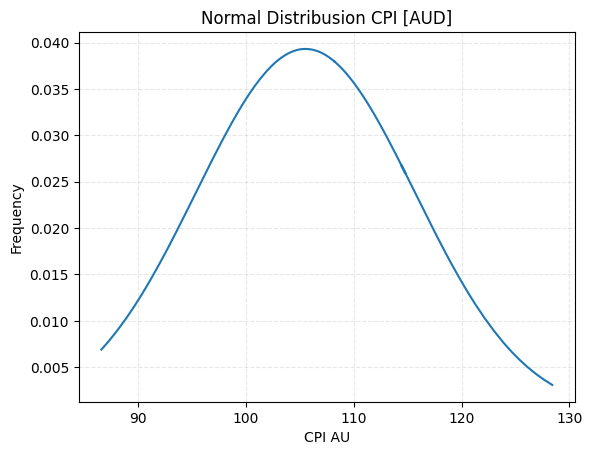

In [39]:
#normal distribusion cpi [aud]
x = df_au['cpi-index']

#mean
df_mean = np.mean(x)
#standard deviation
df_std = np.std(x)

# Calculating probability density function (PDF)
pdf = norm.pdf(x, df_mean, df_std)

plt.plot(x, pdf)
plt.xlabel("CPI AU")
plt.ylabel("Frequency")  
plt.title('Normal Distribusion CPI [AUD]')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

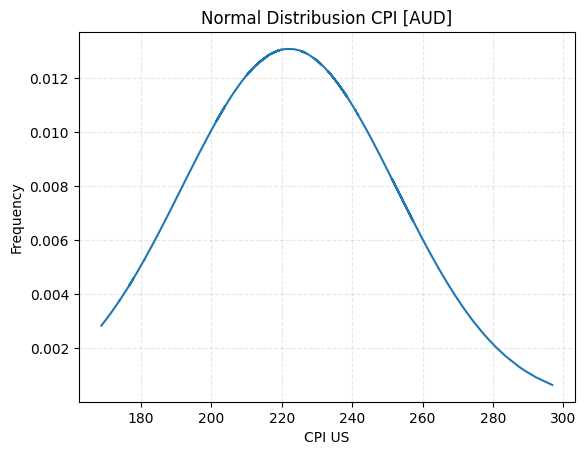

In [40]:
#normal distribusion cpi [usa]
x = df_us['cpi-index']

#mean
df_mean = np.mean(x)
#standard deviation
df_std = np.std(x)

# Calculating probability density function (PDF)
pdf = norm.pdf(x, df_mean, df_std)

plt.plot(x, pdf)
plt.xlabel("CPI US")
plt.ylabel("Frequency")  
plt.title('Normal Distribusion CPI [AUD]')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

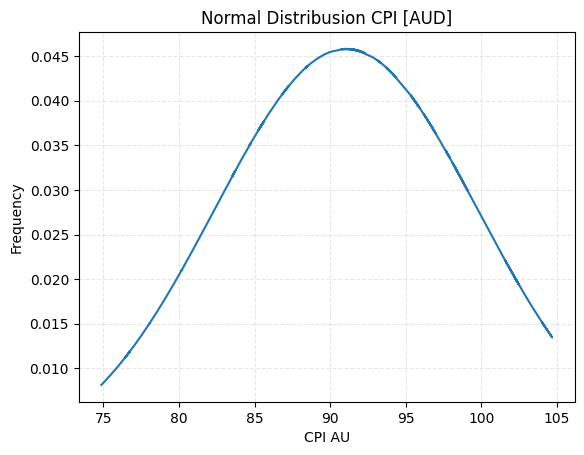

In [41]:
#normal distribusion cpi [eu]
x = df_eu['cpi-index']

#mean
df_mean = np.mean(x)
#standard deviation
df_std = np.std(x)

# Calculating probability density function (PDF)
pdf = norm.pdf(x, df_mean, df_std)

plt.plot(x, pdf)
plt.xlabel("CPI AU")
plt.ylabel("Frequency")  
plt.title('Normal Distribusion CPI [AUD]')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

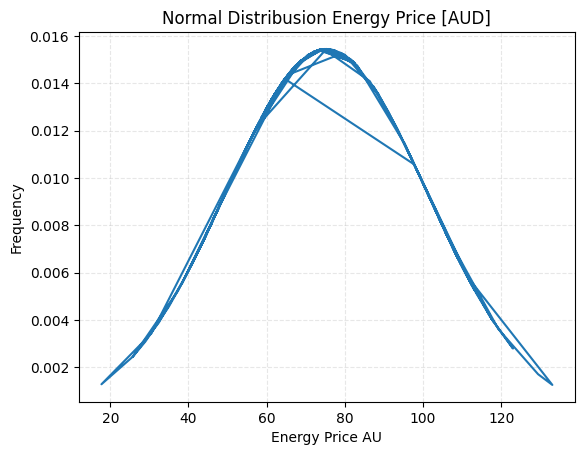

In [42]:
#normal distribusion energy price [aud]
x = df_au['energy_price']

#mean
df_mean = np.mean(x)
#standard deviation
df_std = np.std(x)

# Calculating probability density function (PDF)
pdf = norm.pdf(x, df_mean, df_std)

plt.plot(x, pdf)
plt.xlabel("Energy Price AU")
plt.ylabel("Frequency")  
plt.title('Normal Distribusion Energy Price [AUD]')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

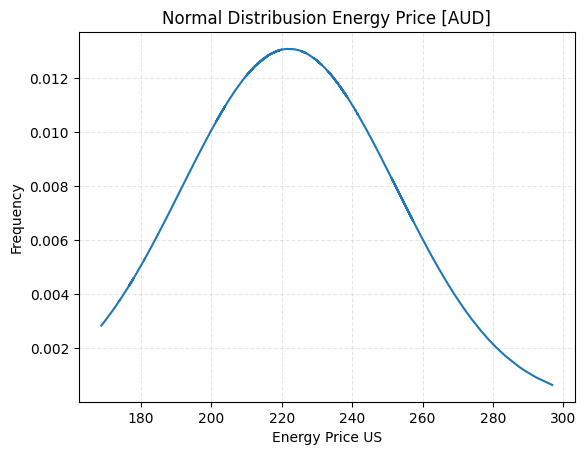

In [43]:
#normal distribusion energy_price [usa]
x = df_us['cpi-index']

#mean
df_mean = np.mean(x)
#standard deviation
df_std = np.std(x)

# Calculating probability density function (PDF)
pdf = norm.pdf(x, df_mean, df_std)

plt.plot(x, pdf)
plt.xlabel("Energy Price US")
plt.ylabel("Frequency")  
plt.title('Normal Distribusion Energy Price [AUD]')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

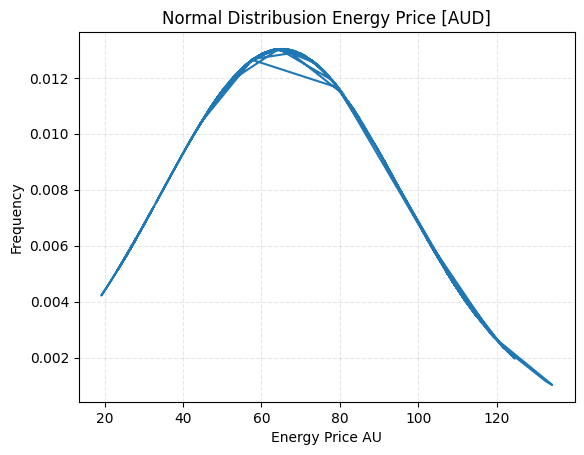

In [44]:
#normal distribusion energy price [eu]
x = df_eu['energy_price']

#mean
df_mean = np.mean(x)
#standard deviation
df_std = np.std(x)

# Calculating probability density function (PDF)
pdf = norm.pdf(x, df_mean, df_std)

plt.plot(x, pdf)
plt.xlabel("Energy Price AU")
plt.ylabel("Frequency")  
plt.title('Normal Distribusion Energy Price [AUD]')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()